<title>Tamil Handwritten Character Recognition</title>

# Tamil Handwritten Character Recognition
### Data Preparation and EDA on HPL and uTHCD datasets


---

#### Installing required packages

In [ ]:
!pip install pandas==2.2.1
!pip install matplotlib==3.8.3
!pip install pillow==10.2.0
!pip install scipy==1.12.0
!pip install scikit-learn==1.2.2
!pip install seaborn==0.12.2
!pip install tqdm==4.66.2
!pip install ipykernel==6.23.1
!pip install ipython==8.18.1
!pip install ipywidgets==8.0.7
!pip install jupyter_client==8.6.0
!pip install jupyter_core==5.5.0
!pip install kaggle==1.6.11
!pip install tensorflow==2.10.0
!pip install keras==2.10.0
!pip install Keras-Preprocessing==1.1.2

---

In [1]:
import os
import shutil
import zipfile
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm

In [2]:
%matplotlib inline

np.random.seed(42)

In [4]:
# If you have your folder setup other than current directory, set that up here
root_dir = os.getcwd()

os.chdir(root_dir) # To make sure the root_dir as the working directory

### Data Extraction

In [5]:
kaggle_api_key_path = '.kaggle/'

In [6]:
os.environ['KAGGLE_CONFIG_DIR'] = os.path.abspath(kaggle_api_key_path)

def get_kaggle_dataset(dataset_name, zipfile_name, extraction_name):
    command = f'kaggle datasets download {dataset_name}'
    subprocess.run(command, shell=True)
    with zipfile.ZipFile(zipfile_name, 'r') as zip_ref:
        zip_ref.extractall(extraction_name)
    print(f'The {zipfile_name} from {dataset_name} has been downloaded and extracted to {extraction_name}')

In [7]:
# Getting HPL dataset
get_kaggle_dataset('seenivasanseeni/tamilhandwrittencharacter', 'tamilhandwrittencharacter.zip', 'hpl')

The tamilhandwrittencharacter.zip from seenivasanseeni/tamilhandwrittencharacter has been downloaded and extracted to hpl


In [9]:
# Getting uTHCD dataset
get_kaggle_dataset('faizalhajamohideen/uthcdtamil-handwritten-database', 'uthcdtamil-handwritten-database.zip', 'uTHCD')

The uthcdtamil-handwritten-database.zip from faizalhajamohideen/uthcdtamil-handwritten-database has been downloaded and extracted to uTHCD


In [15]:
metadata_dir = os.path.join(root_dir, 'metadata')
hpl_base_dir = os.path.join(root_dir, 'processed', 'hpl')  # HPL dataset
uthcd_base_dir = os.path.join(root_dir, 'processed', 'uTHCD')  # uTHCD dataset
docs_dir = os.path.join(root_dir, 'scanned_documents') # Directory for the scanned documents

for fldr in [metadata_dir, hpl_base_dir, uthcd_base_dir, docs_dir]:
    if not os.path.exists(fldr):
        os.makedirs(fldr, mode=777)

## Data Preparation

### HPL

In [63]:
data_src_dir = os.path.join(root_dir, 'hpl', 'tamil_dataset_offline')
print('Data Source directory for HPL: ', data_src_dir)

Data Source directory for HPL:  c:\Users\infor\Documents\AAIML\local_repo\CSCN8010-lab-submissions\students_submissions\8883828\hpl\tamil_dataset_offline


In [64]:
user_list = os.listdir(data_src_dir)
test_users = np.random.choice(user_list, int(len(user_list) * 0.4))
vaildation_users, test_users = test_users[:len(test_users)//2], test_users[len(test_users)//2:]
print(f'Total: {len(user_list)}\nTraining: {len(user_list) - len(test_users) - len(vaildation_users)}')
print(f'Validation: {len(vaildation_users)}\nTesting: {len(test_users)}')

Total: 169
Training: 102
Validation: 33
Testing: 34


#### Extracting Metadata

In [65]:
meta_data = []
for usr_dir in tqdm(os.listdir(data_src_dir), 'User Folders'):
    for root, dirs, img_files in os.walk(os.path.join(data_src_dir, usr_dir)):
        for img_file in img_files:
            try:
                src_fullpath = os.path.join(root, img_file)
                if not os.path.isfile(src_fullpath) or os.path.splitext(img_file)[-1] != '.tiff':
                    continue
                class_idx = int(img_file[:3])
                src_image = Image.open(src_fullpath)
                width, height = src_image.size
                dataset = 'test' if usr_dir in test_users else 'validation' if usr_dir in vaildation_users else 'train'
                new_filename = usr_dir + '_' + img_file
                new_filepath = os.path.join(hpl_base_dir, dataset, str(class_idx))
                meta_data.append((dataset, usr_dir, src_fullpath, width, height, new_filepath, new_filename, class_idx))
            except Exception as e:
                print(f'Exception occured while processing {os.path.join(root, img_file)}')
df_meta = pd.DataFrame(meta_data, columns=['dataset', 'usr_dir', 'src_filename', 'src_width', 'src_height', 'filepath', 'filename', 'class_idx'])
df_meta

User Folders:  46%|████▌     | 77/169 [03:04<06:39,  4.34s/it]

Exception occured while processing c:\Users\infor\Documents\AAIML\local_repo\CSCN8010-lab-submissions\students_submissions\8883828\hpl\tamil_dataset_offline\usr_174\t03.tiff


User Folders: 100%|██████████| 169/169 [10:47<00:00,  3.83s/it]


,dataset,usr_dir,src_filename,src_width,src_height,filepath,filename,class_idx
0,train,usr_100,c:\Users\infor\Documents\AAIML\local_repo\CSCN...,234,123,c:\Users\infor\Documents\AAIML\local_repo\CSCN...,usr_100_000t01.tiff,0
1,train,usr_100,c:\Users\infor\Documents\AAIML\local_repo\CSCN...,152,66,c:\Users\infor\Documents\AAIML\local_repo\CSCN...,usr_100_000t02.tiff,0
2,train,usr_100,c:\Users\infor\Documents\AAIML\local_repo\CSCN...,282,167,c:\Users\infor\Documents\AAIML\local_repo\CSCN...,usr_100_001t01.tiff,1
3,train,usr_100,c:\Users\infor\Documents\AAIML\local_repo\CSCN...,147,91,c:\Users\infor\Documents\AAIML\local_repo\CSCN...,usr_100_001t02.tiff,1
4,train,usr_100,c:\Users\infor\Documents\AAIML\local_repo\CSCN...,237,98,c:\Users\infor\Documents\AAIML\local_repo\CSCN...,usr_100_002t01.tiff,2
...,...,...,...,...,...,...,...,...
77547,test,usr_54,c:\Users\infor\Documents\AAIML\local_repo\CSCN...,190,150,c:\Users\infor\Documents\AAIML\local_repo\CSCN...,usr_54_153t02.tiff,153
77548,test,usr_54,c:\Users\infor\Documents\AAIML\local_repo\CSCN...,179,153,c:\Users\infor\Documents\AAIML\local_repo\CSCN...,usr_54_154t01.tiff,154
77549,test,usr_54,c:\Users\infor\Documents\AAIML\local_repo\CSCN...,193,165,c:\Users\infor\Documents\AAIML\local_repo\CSCN...,usr_54_154t02.tiff,154
77550,test,usr_54,c:\Users\infor\Documents\AAIML\local_repo\CSCN...,158,106,c:\Users\infor\Documents\AAIML\local_repo\CSCN...,usr_54_155t01.tiff,155


#### Finding Outliers

In [66]:
df_meta[['src_height', 'src_width']].describe()

,src_height,src_width
count,77552.000000,77552.000000
mean,120.478427,141.616438
std,32.632457,50.609323
min,32.000000,31.000000
25%,98.000000,106.000000
50%,119.000000,133.000000
75%,141.000000,169.000000
max,283.000000,655.000000


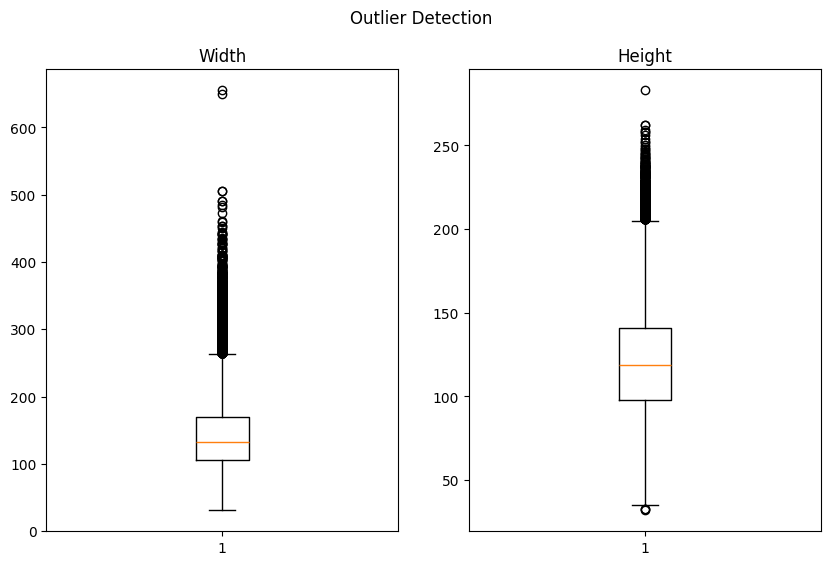

In [67]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

axes[0].boxplot(df_meta['src_width'])
axes[0].set_title('Width')
axes[1].boxplot(df_meta['src_height'])
axes[1].set_title('Height')
plt.suptitle('Outlier Detection')
plt.show()
# df_meta['src_width'].plot(kind='box')

In [68]:
df_meta[df_meta['src_width'] > 600]

,dataset,usr_dir,src_filename,src_width,src_height,filepath,filename,class_idx
50805,test,usr_26,c:\Users\infor\Documents\AAIML\local_repo\CSCN...,650,132,c:\Users\infor\Documents\AAIML\local_repo\CSCN...,usr_26_014t04.tiff,14
50811,test,usr_26,c:\Users\infor\Documents\AAIML\local_repo\CSCN...,655,145,c:\Users\infor\Documents\AAIML\local_repo\CSCN...,usr_26_014t10.tiff,14


In [71]:
for outlier in df_meta[df_meta['src_width'] > 600]['src_filename'].to_list():
    Image.open(outlier).show()

#### Removing outliers

In [72]:
df_meta = df_meta[df_meta['src_width'] < 600]

In [73]:
df_meta[['src_height', 'src_width']].describe()

,src_height,src_width
count,77550.000000,77550.000000
mean,120.477963,141.603262
std,32.632732,50.543427
min,32.000000,31.000000
25%,98.000000,106.000000
50%,119.000000,133.000000
75%,141.000000,169.000000
max,283.000000,506.000000


In [74]:
Image.open(df_meta[df_meta['src_width'] == df_meta['src_width'].max()]['src_filename'].to_list()[0]).show()
Image.open(df_meta[df_meta['src_height'] == df_meta['src_height'].max()]['src_filename'].to_list()[0]).show()

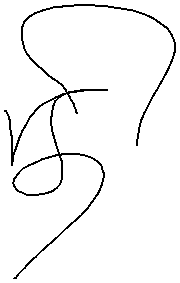

In [83]:
Image.open(df_meta[df_meta['src_height'] == df_meta['src_height'].max()]['src_filename'].to_list()[0])

In [75]:
Image.open(df_meta[df_meta['src_width'] == df_meta['src_width'].min()]['src_filename'].to_list()[0]).show()
Image.open(df_meta[df_meta['src_height'] == df_meta['src_height'].min()]['src_filename'].to_list()[0]).show()

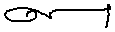

In [82]:
Image.open(df_meta[df_meta['src_height'] == df_meta['src_height'].min()]['src_filename'].to_list()[0])

In [76]:
print('Distinct class in ')
print(f"full dataset   : {df_meta['class_idx'].nunique()}")
print(f"training set   : {df_meta[df_meta['dataset']=='train']['class_idx'].nunique()}")
print(f"testing set    : {df_meta[df_meta['dataset']=='test']['class_idx'].nunique()}")
print(f"validation set : {df_meta[df_meta['dataset']=='validation']['class_idx'].nunique()}")

Distinct class in 
full dataset   : 156
training set   : 156
testing set    : 156
validation set : 156


#### Size Standardization

In [77]:
df_meta['src_width'].max(), df_meta['src_height'].max()

(506, 283)

In [78]:
target_size = (512, 288)

In [79]:
def image_padding(img_path, target_size):
    img_obj = Image.open(img_path)
    # img_obj.show()
    left_padding = (target_size[0] - img_obj.size[0]) // 2
    top_padding = (target_size[1] - img_obj.size[1]) // 2
    padded_image = Image.new('RGB', target_size, (255, 255, 255))
    padded_image.paste(img_obj, (left_padding, top_padding))
    # padded_image.show()
    return padded_image

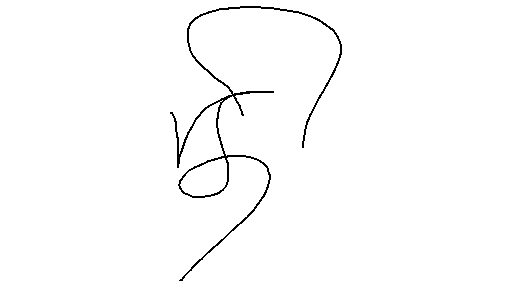

In [80]:
image_padding(df_meta[df_meta['src_height'] == df_meta['src_height'].max()]['src_filename'].to_list()[0], target_size)

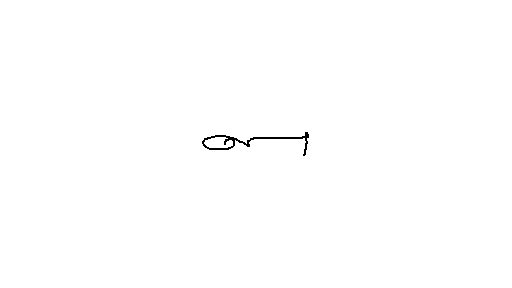

In [84]:
image_padding(df_meta[df_meta['src_height'] == df_meta['src_height'].min()]['src_filename'].to_list()[0], target_size)

#### Reorganize images

In [87]:
if os.path.exists(hpl_base_dir):
    try:
        shutil.rmtree(hpl_base_dir)
    except Exception as e:
        print(e)
os.makedirs(hpl_base_dir)

for subdir in df_meta['filepath'].unique():
    os.makedirs(subdir)

In [88]:
for i, row in tqdm(df_meta.iterrows(), total=df_meta.shape[0]):
    img_obj = Image.open(row['src_filename']).convert('L')  # Convert to grayscale
    # img_obj.show()
    
    left_padding = (target_size[0] - img_obj.size[0]) // 2
    top_padding = (target_size[1] - img_obj.size[1]) // 2
    
    padded_image = Image.new('L', target_size, 255)  # 'L' mode for grayscale
    padded_image.paste(img_obj, (left_padding, top_padding))
    
    padded_image.save(os.path.join(row['filepath'], row['filename']))


100%|██████████| 77550/77550 [07:36<00:00, 169.74it/s]


In [89]:
df_meta.to_csv(os.path.join(metadata_dir, 'hpl_metadata.csv'), index=False)

---

### uTHCD

In [11]:
print(os.path.join(root_dir, 'uTHCD', 'uTHCD_d(90-10-split)', '90-10-split'))

c:\Users\infor\Documents\AAIML\local_repo\CSCN8010-lab-submissions\students_submissions\8883828\THCR\uTHCD\uTHCD_d(90-10-split)\90-10-split


In [12]:
data_src_dir = os.path.join(root_dir, 'uTHCD', 'uTHCD_d(90-10-split)', '90-10-split')
# data_dir = os.path.join(root_dir, 'processed', 'uTCHCD')

# os.listdir to list directories for 'train' and 'test' based on your 90/10 split
train_user_list = os.listdir(os.path.join(data_src_dir, 'train'))
test_user_list = os.listdir(os.path.join(data_src_dir, 'test'))

In [51]:
# the test set is already provided, you wouldn't normally split it further,
# but here's how you could if you needed to create a validation set from the test set.
test_users = np.random.choice(test_user_list, int(len(test_user_list) * 0.5))
validation_users, test_users = test_users[:len(test_users)//2], test_users[len(test_users)//2:]

print(f'Total: {len(train_user_list) + len(test_user_list)}')
print(f'Training: {len(train_user_list)}')
print(f'Validation: {len(validation_users)}')
print(f'Testing: {len(test_users)}')

Total: 90950
Training: 81900
Validation: 2262
Testing: 2263


In [13]:
# Directories for the uTHCD dataset
train_dir = os.path.join(data_src_dir, 'train')
test_dir = os.path.join(data_src_dir, 'test')

# Empty list to store metadata
meta_data = []

# Function to process images and extract metadata
def process_images(image_directory, dataset_type):
    for img_file in tqdm(os.listdir(image_directory), f'Processing {dataset_type} images'):
        try:
            src_fullpath = os.path.join(image_directory, img_file)
            if not os.path.isfile(src_fullpath) or os.path.splitext(img_file)[-1] != '.bmp':
                continue
            class_idx = int(img_file.split('_')[1].split('.')[0])  # Assumes filename format is `number_class.bmp`
            src_image = Image.open(src_fullpath)
            width, height = src_image.size
            dataset = dataset_type
            new_filename = img_file
            new_filepath = os.path.join(image_directory, img_file)  # This could be a processed folder path if needed
            meta_data.append((dataset, src_fullpath, width, height, new_filepath, new_filename, class_idx))
        except Exception as e:
            print(f'Exception occurred while processing {src_fullpath}: {e}')

# Process train and test images
process_images(train_dir, 'train')
process_images(test_dir, 'test')

# Create DataFrame from the metadata list
df_meta = pd.DataFrame(meta_data, columns=['dataset', 'src_filename', 'src_width', 'src_height', 'filepath', 'filename', 'class_idx'])

Processing train images:   0%|          | 0/81900 [00:00<?, ?it/s]

Processing test images: 100%|██████████| 9050/9050 [00:51<00:00, 176.53it/s]


In [16]:
# Save DataFrame to a CSV file
df_meta.to_csv(os.path.join(metadata_dir, 'uTHCD_metadata.csv'), index=False)

In [17]:
df_meta[['src_height', 'src_width']].describe()

,src_height,src_width
count,90950.0,90950.0
mean,64.0,64.0
std,0.0,0.0
min,64.0,64.0
25%,64.0,64.0
50%,64.0,64.0
75%,64.0,64.0
max,64.0,64.0


In [18]:
print('Distinct class in ')
print(f"full dataset   : {df_meta['class_idx'].nunique()}")
print(f"training set   : {df_meta[df_meta['dataset']=='train']['class_idx'].nunique()}")
print(f"testing set    : {df_meta[df_meta['dataset']=='test']['class_idx'].nunique()}")
print(f"validation set : {df_meta[df_meta['dataset']=='validation']['class_idx'].nunique()}")

Distinct class in 
full dataset   : 156
training set   : 156
testing set    : 156
validation set : 0


In [20]:
from sklearn.model_selection import train_test_split

validation_split = 0.15

df_train = df_meta[df_meta['dataset'] == 'train']
train_idxs, val_idxs = train_test_split(df_train.index, test_size=validation_split, stratify=df_train['class_idx'])

df_meta.loc[val_idxs, 'dataset'] = 'validation'


for index, row in tqdm(df_meta.iterrows(), total=df_meta.shape[0]):
    # Open the image
    image = Image.open(row['src_filename']).convert('L')  # Convert to grayscale
    
    # Determine the dataset folder based on the 'dataset' column
    dataset_folder = row['dataset']

    # Construct the directory path based on dataset and class_idx within data_dir
    class_dir = os.path.join(uthcd_base_dir, dataset_folder, str(row['class_idx']))
    os.makedirs(class_dir, exist_ok=True)  # Create the directory if it doesn't exist

    # Construct the full path for the new image
    save_path = os.path.join(class_dir, row['filename'])

    # Save the image
    image.save(save_path)

100%|██████████| 90950/90950 [01:40<00:00, 904.89it/s] 


In [21]:
df_meta['dataset'].value_counts()

dataset
train         69615
validation    12285
test           9050
Name: count, dtype: int64

In [22]:
print('Distinct class in ')
print(f"full dataset   : {df_meta['class_idx'].nunique()}")
print(f"training set   : {df_meta[df_meta['dataset']=='train']['class_idx'].nunique()}")
print(f"testing set    : {df_meta[df_meta['dataset']=='test']['class_idx'].nunique()}")
print(f"validation set : {df_meta[df_meta['dataset']=='validation']['class_idx'].nunique()}")

Distinct class in 
full dataset   : 156
training set   : 156
testing set    : 156
validation set : 156


In [19]:
validation_split = 0.2

for index, row in tqdm(df_meta.iterrows(), total=df_meta.shape[0]):
    # Open the image
    image = Image.open(row['src_filename']).convert('L')  # Convert to grayscale

    # Check if this row should go into the validation set instead of its current dataset designation
    if row['dataset'] == 'train':
        # Use index to decide if this should be part of validation instead
        if index < df_meta.shape[0] * validation_split:
            dataset_folder = 'validation'
        else:
            dataset_folder = 'train'
    else:
        dataset_folder = row['dataset']

    # Construct the directory path based on dataset and class_idx within data_dir
    class_dir = os.path.join(uthcd_base_dir, dataset_folder, str(row['class_idx']))
    os.makedirs(class_dir, exist_ok=True)  # Create the directory if it doesn't exist

    # Construct the full path for the new image
    save_path = os.path.join(class_dir, row['filename'])

    # Save the image
    image.save(save_path)

100%|██████████| 90950/90950 [01:30<00:00, 1002.50it/s]


---

## EDA

In [90]:
hpl_metadata = pd.read_csv(os.path.join(metadata_dir, 'hpl_metadata.csv'))
utchd_metadata = pd.read_csv(os.path.join(metadata_dir, 'uTHCD_metadata.csv'))

### Data Overview

In [91]:
print(hpl_metadata.info())
hpl_metadata.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77550 entries, 0 to 77549
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   dataset       77550 non-null  object
 1   usr_dir       77550 non-null  object
 2   src_filename  77550 non-null  object
 3   src_width     77550 non-null  int64 
 4   src_height    77550 non-null  int64 
 5   filepath      77550 non-null  object
 6   filename      77550 non-null  object
 7   class_idx     77550 non-null  int64 
dtypes: int64(3), object(5)
memory usage: 4.7+ MB
None


,dataset,usr_dir,src_filename,src_width,src_height,filepath,filename,class_idx
0,train,usr_100,c:\Users\infor\Documents\AAIML\local_repo\CSCN...,234,123,c:\Users\infor\Documents\AAIML\local_repo\CSCN...,usr_100_000t01.tiff,0
1,train,usr_100,c:\Users\infor\Documents\AAIML\local_repo\CSCN...,152,66,c:\Users\infor\Documents\AAIML\local_repo\CSCN...,usr_100_000t02.tiff,0
2,train,usr_100,c:\Users\infor\Documents\AAIML\local_repo\CSCN...,282,167,c:\Users\infor\Documents\AAIML\local_repo\CSCN...,usr_100_001t01.tiff,1
3,train,usr_100,c:\Users\infor\Documents\AAIML\local_repo\CSCN...,147,91,c:\Users\infor\Documents\AAIML\local_repo\CSCN...,usr_100_001t02.tiff,1
4,train,usr_100,c:\Users\infor\Documents\AAIML\local_repo\CSCN...,237,98,c:\Users\infor\Documents\AAIML\local_repo\CSCN...,usr_100_002t01.tiff,2


In [92]:
print(utchd_metadata.info())
utchd_metadata.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90950 entries, 0 to 90949
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   dataset       90950 non-null  object
 1   src_filename  90950 non-null  object
 2   src_width     90950 non-null  int64 
 3   src_height    90950 non-null  int64 
 4   filepath      90950 non-null  object
 5   filename      90950 non-null  object
 6   class_idx     90950 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 4.9+ MB
None


,dataset,src_filename,src_width,src_height,filepath,filename,class_idx
0,train,c:\Users\infor\Documents\AAIML\local_repo\CSCN...,64,64,c:\Users\infor\Documents\AAIML\local_repo\CSCN...,0004_000.bmp,0
1,train,c:\Users\infor\Documents\AAIML\local_repo\CSCN...,64,64,c:\Users\infor\Documents\AAIML\local_repo\CSCN...,0004_081.bmp,81
2,train,c:\Users\infor\Documents\AAIML\local_repo\CSCN...,64,64,c:\Users\infor\Documents\AAIML\local_repo\CSCN...,0004_082.bmp,82
3,train,c:\Users\infor\Documents\AAIML\local_repo\CSCN...,64,64,c:\Users\infor\Documents\AAIML\local_repo\CSCN...,0004_083.bmp,83
4,train,c:\Users\infor\Documents\AAIML\local_repo\CSCN...,64,64,c:\Users\infor\Documents\AAIML\local_repo\CSCN...,0004_084.bmp,84


For the HPL dataset:

The dataset contains 77,552 entries, each with 8 features.
There are no null values, which indicates that the dataset is complete without any missing entries.
The data types are appropriate for the type of data, with int64 for numerical values like width, height, and class index, and object for strings.
The src_width and src_height columns provide information about the dimensions of the images, and class_idx is a numerical label for the class.
The filepath and filename contain the file paths and file names, respectively, indicating the location of images on the disk.

For the uTHCD dataset:

There are more entries in the uTHCD dataset (90,950) compared to the HPL dataset.
The structure of the data is similar to that of the HPL dataset with one less column; it does not have a usr_dir which suggests that this dataset may not be segmented by user or writer of the characters, unlike HPL.
Image dimensions are consistent (src_width and src_height are both 64), which might indicate preprocessed image sizes are standardized.
No missing values are reported, which simplifies the preprocessing step as no imputation is required.
The class indices are the same between both datasets, suggesting that they classify similar characters or classes.
Commentary on Data Consistency and Quality:

Both datasets are clean and well-structured, with no missing entries, which is ideal for building machine learning models.
The consistent image sizes in uTHCD suggest that less preprocessing might be required compared to the HPL dataset where image sizes vary.
The absence of usr_dir in the uTHCD might mean the EDA and subsequent models cannot account for individual writer variations, which could be a factor in handwriting recognition tasks.
Next Steps for EDA:

Next lets visualize 

### Class Distribution


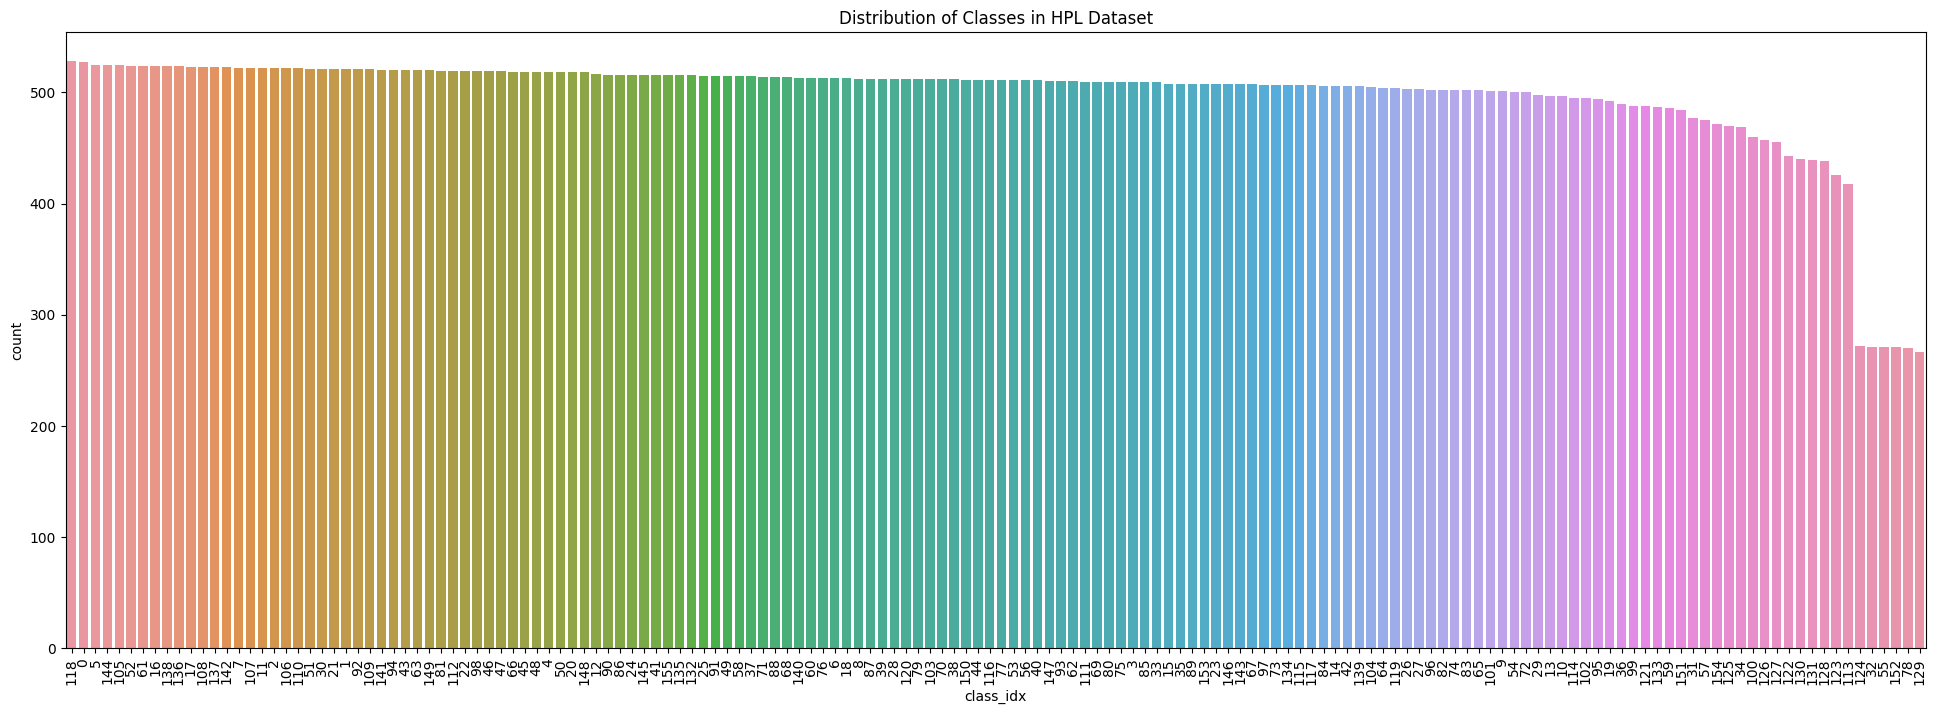

In [93]:
plt.figure(figsize=(24, 8))
sns.countplot(data=hpl_metadata, x='class_idx', order = hpl_metadata['class_idx'].value_counts().index)
plt.xticks(rotation=90)
plt.title('Distribution of Classes in HPL Dataset')
plt.show()

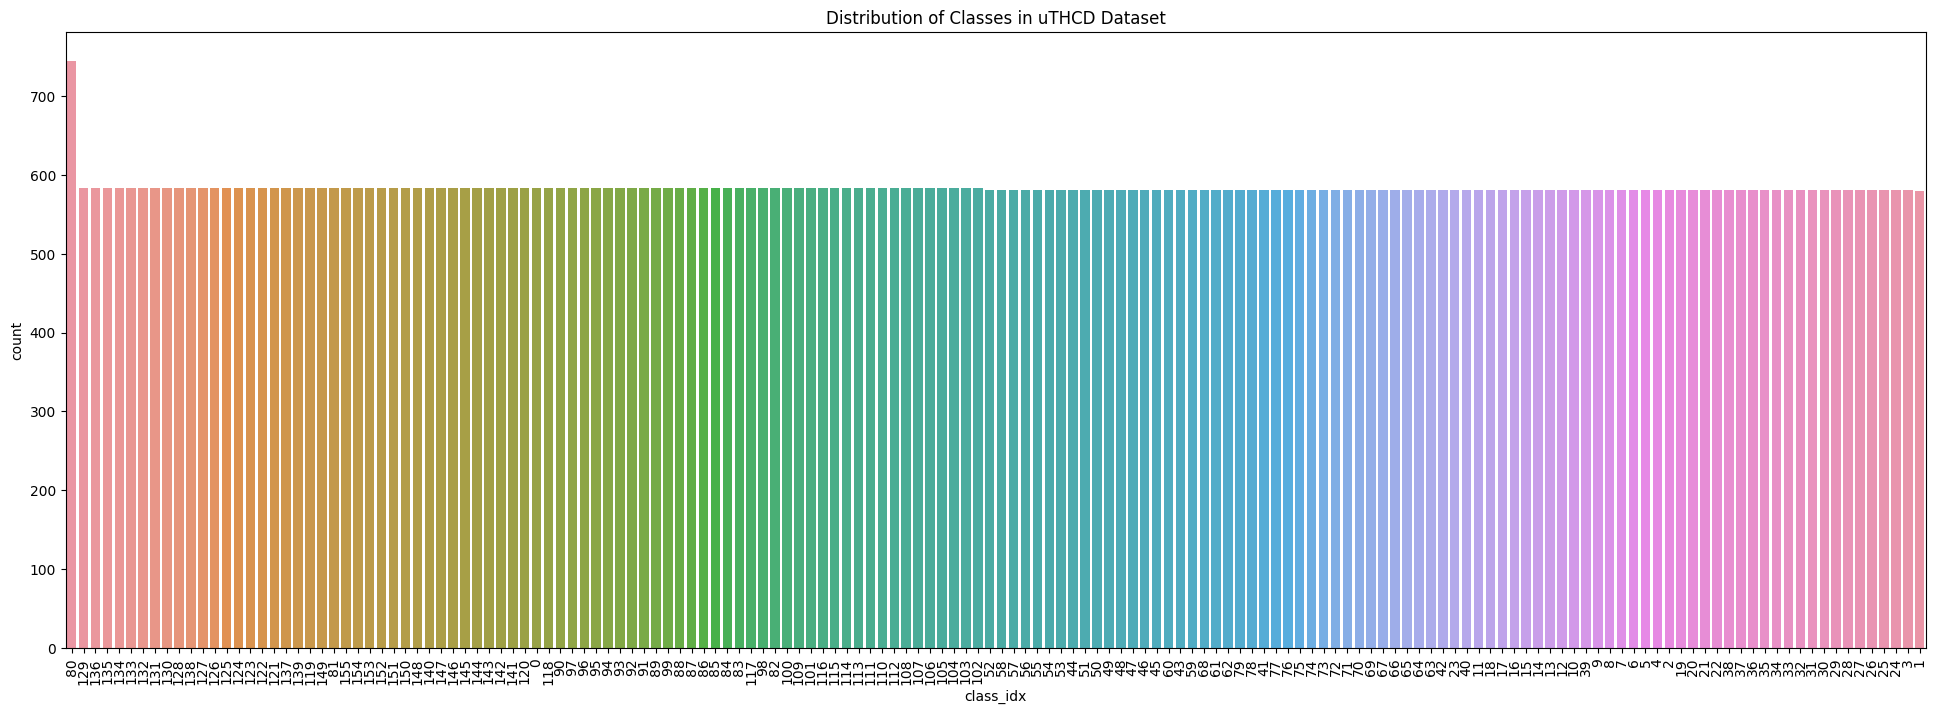

In [94]:
# Plot the distribution of classes for uTHCD dataset
plt.figure(figsize=(24, 8))
sns.countplot(data=utchd_metadata, x='class_idx', order = utchd_metadata['class_idx'].value_counts().index)
plt.xticks(rotation=90)
plt.title('Distribution of Classes in uTHCD Dataset')
plt.show()

It's clear from these visuals that both datasets exhibit some variance in class representation; some classes have more samples than others. This kind of imbalance can affect the performance of machine learning models, as they might become biased towards classes with more samples.

It's also good to note that both datasets appear to cover a broad range of classes quite extensively, which is beneficial for building a robust model.

### Image Size Distribution

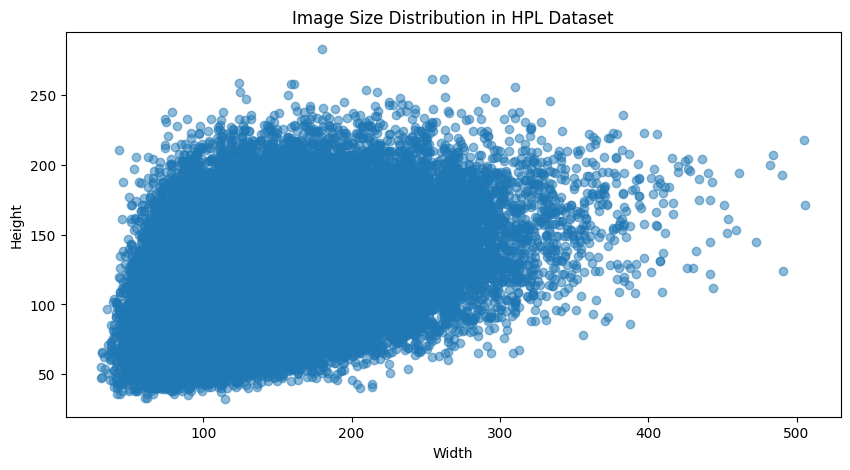

In [95]:
plt.figure(figsize=(10, 5))
plt.scatter(hpl_metadata['src_width'], hpl_metadata['src_height'], alpha=0.5)
plt.title('Image Size Distribution in HPL Dataset')
plt.xlabel('Width')
plt.ylabel('Height')
plt.show()

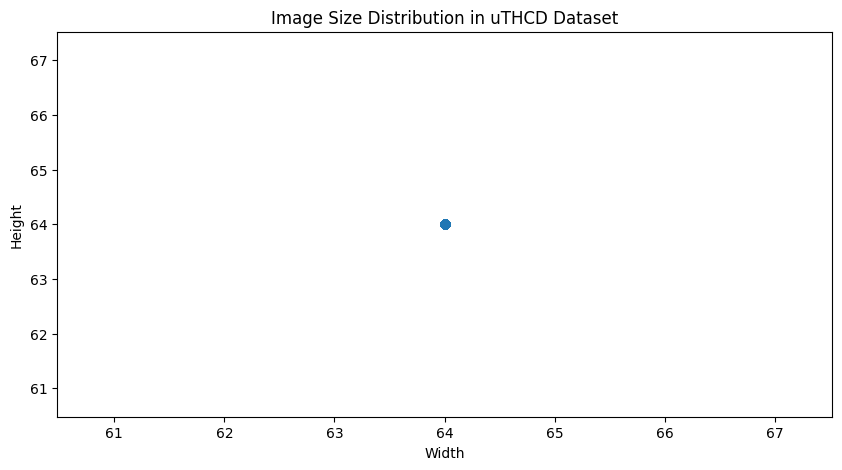

In [96]:
plt.figure(figsize=(10, 5))
plt.scatter(utchd_metadata['src_width'], utchd_metadata['src_height'], alpha=0.5)
plt.title('Image Size Distribution in uTHCD Dataset')
plt.xlabel('Width')
plt.ylabel('Height')
plt.show()

We can notice that the images in HPL dataset have different size dimensions wheras the uTHCD dataset images are of same size (64,64)

### Common Classes

In [97]:
# Assuming 'class_idx' is the column indicating the class/letter
unique_classes_hpl = set(hpl_metadata['class_idx'].unique())
unique_classes_utchd = set(utchd_metadata['class_idx'].unique())

common_classes = unique_classes_hpl.intersection(unique_classes_utchd)
unique_to_hpl = unique_classes_hpl.difference(unique_classes_utchd)
unique_to_utchd = unique_classes_utchd.difference(unique_classes_hpl)

print("Common classes:", common_classes)
print("Unique to HPL:", unique_to_hpl)
print("Unique to uTHCD:", unique_to_utchd)


Common classes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155}
Unique to HPL: set()
Unique to uTHCD: set()


Both the Datasets have common classes because they have 156 characters which represents each class

### Sample images

In [98]:
import random
from PIL import Image
from IPython.display import display

def display_sample_images(df, n_classes=5):
    # Randomly select n_classes classes from the dataset
    selected_classes = random.sample(sorted(df['class_idx'].unique()), n_classes)
    
    for class_idx in selected_classes:
        # Sample one image from each selected class
        sample_image = df[df['class_idx'] == class_idx].sample(n=1)
        print(f"Class {class_idx}:")
        for _, row in sample_image.iterrows():
            img = Image.open(row['src_filename'])
            display(img)


Sample images from HPL Dataset:
Class 89:


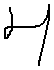

Class 101:


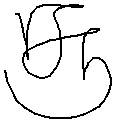

Class 13:


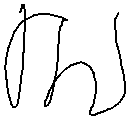

Class 66:


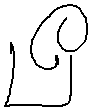

Class 99:


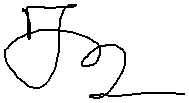

In [99]:
print("Sample images from HPL Dataset:")
display_sample_images(hpl_metadata)

Sample images from uTHCD Dataset:
Class 147:


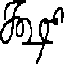

Class 77:


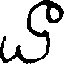

Class 11:


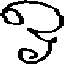

Class 152:


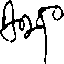

Class 81:


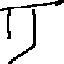

In [100]:
print("Sample images from uTHCD Dataset:")
display_sample_images(utchd_metadata)

These sample images confirm the different sizes and show 1 image from random 5 classes

### Splitting datasets into Train, Test, and Valid

In [103]:
def get_processed_metadata(base_dir, dataset_name, output_dir):
    categories = ['train', 'test', 'valid']
    data = []

    # Loop through each category (train, test, valid)
    for category in categories:
        category_dir = os.path.join(base_dir, category)
        # If the category directory exists
        if not os.path.isdir(category_dir):
            continue
        # Loop through each class directory
        for class_dir in os.listdir(category_dir):
            class_dir_path = os.path.join(category_dir, class_dir)
            # Check if it's a directory
            if not os.path.isdir(class_dir_path):
                continue
            # List all image files in the directory
            for image_file in os.listdir(class_dir_path):
                if image_file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.tif')):
                    # Construct full image file path
                    image_file_path = os.path.join(class_dir_path, image_file)
                    # Append to data list
                    data.append([dataset_name, category, class_dir, image_file_path])

    # Create a DataFrame
    df = pd.DataFrame(data, columns=['Dataset', 'Category', 'Class', 'FilePath'])
    
    return df

In [104]:
hpl_metadata_processed = get_processed_metadata(hpl_base_dir, 'hpl', metadata_dir)
utchd_metadata_processed = get_processed_metadata(uthcd_base_dir, 'uthcd', metadata_dir)

#### Data Overview

In [105]:
print(hpl_metadata_processed.info())
hpl_metadata_processed.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59607 entries, 0 to 59606
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Dataset   59607 non-null  object
 1   Category  59607 non-null  object
 2   Class     59607 non-null  object
 3   FilePath  59607 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB
None


,Dataset,Category,Class,FilePath
0,hpl,train,0,c:\Users\infor\Documents\AAIML\local_repo\CSCN...
1,hpl,train,0,c:\Users\infor\Documents\AAIML\local_repo\CSCN...
2,hpl,train,0,c:\Users\infor\Documents\AAIML\local_repo\CSCN...
3,hpl,train,0,c:\Users\infor\Documents\AAIML\local_repo\CSCN...
4,hpl,train,0,c:\Users\infor\Documents\AAIML\local_repo\CSCN...


In [106]:
print(utchd_metadata_processed.info())
utchd_metadata_processed.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72760 entries, 0 to 72759
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Dataset   72760 non-null  object
 1   Category  72760 non-null  object
 2   Class     72760 non-null  object
 3   FilePath  72760 non-null  object
dtypes: object(4)
memory usage: 2.2+ MB
None


,Dataset,Category,Class,FilePath
0,uthcd,train,0,c:\Users\infor\Documents\AAIML\local_repo\CSCN...
1,uthcd,train,0,c:\Users\infor\Documents\AAIML\local_repo\CSCN...
2,uthcd,train,0,c:\Users\infor\Documents\AAIML\local_repo\CSCN...
3,uthcd,train,0,c:\Users\infor\Documents\AAIML\local_repo\CSCN...
4,uthcd,train,0,c:\Users\infor\Documents\AAIML\local_repo\CSCN...


**Data Size and Completeness:**

The HPL dataset contains 67,859 entries, while the uTHCD dataset contains 90,845 entries. Both datasets are complete with no null values, indicating good data completeness and integrity.

**Structure and Consistency:**

Both datasets share a consistent structure with four columns, which should facilitate comparison and combination if needed. The columns are 'Dataset' (denoting the source dataset), 'Category' (likely representing train/test/validation splits), 'Class' (the label for each image), and 'FilePath' (the location of the image file).

**Data Types:**

The data types are appropriate for the contents of each column, with categorical data represented as 'object' (string) type and numerical labels as 'int64'. This suggests that the data is ready for use in typical machine learning workflows without the need for type conversion.

**Class Labels:**

The 'Class' column in both datasets indicates that classes are encoded as integers, which is standard for classification tasks. Ensure that the class indices correspond correctly to the class labels across both datasets.

**File Paths:**

The 'FilePath' entries point to where the processed images are stored. These paths will be essential for loading images during model training or analysis. The paths look to be absolute paths on my local machine, which is fine for personal use but would need modification for sharing or deploying the model.



#### Mising Values

In [108]:
hpl_metadata_processed.isnull().sum()

Dataset     0
Category    0
Class       0
FilePath    0
dtype: int64

In [109]:
utchd_metadata_processed.isnull().sum()

Dataset     0
Category    0
Class       0
FilePath    0
dtype: int64

There are no missing values

Both the datasets have been preprocessed to be in the same IMAGE DIMENSIONS: 512 X 288

#### Sample Images

In [110]:
def display_sample_images(df, n=5):
    sample_files = df['FilePath'].sample(n)
    plt.figure(figsize=(15, 15))
    for i, file in enumerate(sample_files):
        img = Image.open(file)
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

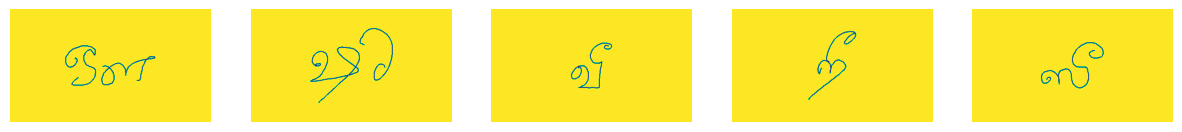

In [111]:
# Display sample images from HPL dataset
display_sample_images(hpl_metadata_processed)

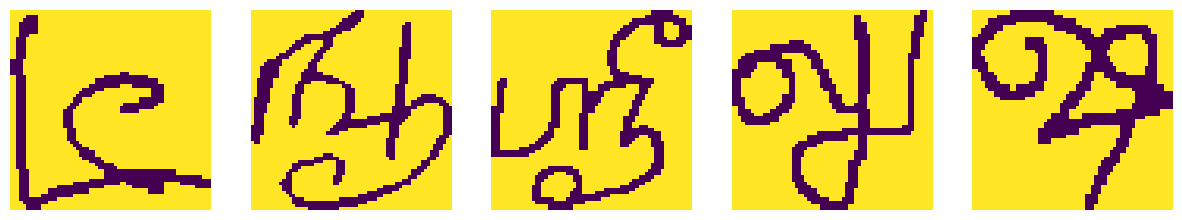

In [112]:
# Display sample images from uTHCD dataset
display_sample_images(utchd_metadata_processed)

The preprocessing includes a step to change to greyscale from RGB which has included a yellow background on the uTHCD dataset which needs to be corrected

---

### Hypothesis Testing

#### Chi-Squared

In [119]:
from scipy.stats import chi2_contingency

# Get the counts of each class for both datasets
hpl_counts = hpl_metadata_processed['Class'].value_counts().sort_index()
utchd_counts = utchd_metadata_processed['Class'].value_counts().sort_index()

# Create the contingency table as a DataFrame
contingency_table = pd.DataFrame({
    'HPL': hpl_counts,
    'uTHCD': utchd_counts
})

# Perform the chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi2 statistic: {chi2}, p-value: {p}")

# Interpret the results
if p < 0.05:
    print("There is a significant difference between the class distributions in the two datasets.")
else:
    print("No significant difference between the class distributions in the two datasets.")


Chi2 statistic: 602.6669643698726, p-value: 4.8778506239235254e-54
There is a significant difference between the class distributions in the two datasets.


#### Paired t-test

In [131]:
# The time taken (in mins) for transcribing 4 documents manually
manual_time = np.array([180, 240, 250, 300])

# The time taken (in mins) for scanning the documents and transcribing using HCRT model
# Since the complete model is not yet ready, these timings are given by guess.
model_time = np.array([3, 2.1, 2.8, 3.1])

In [133]:
from scipy.stats import ttest_rel

t_stat, p_value = ttest_rel(manual_time, model_time)

print(f'T-Statistic:\t{t_stat}')
print(f'P-Value:\t{p_value}')

T-Statistic:	9.745471981518408
P-Value:	0.002295305035604119


In [134]:
if p_value < 0.05:
    print('Null hypothesis is rejected.\nThe HCRT model significantly reduces the transcription time.')
else:
    print('Unable to reject the Null hypothesis.\nThe HCRT model does not significantly reduce the transcription time.')

Null hypothesis is rejected.
The HCRT model significantly reduces the transcription time.


---